# Compute and save disk opacity

We produce two tables, both saving opaicty per total (gas+dust) mass.

One contains mean opacities, as a function of T, amax, and slope.

The other contains opacities as a function of T, lambda, amax, and slope. (Here the T grid just separate different regimes of sublimation.)

In [1]:
from util import *
import matplotlib.pyplot as plt
from interp_table import InterpTable
import pickle

In [2]:
# load grain opacity
grain_opacity = pickle.load(open('./data/opacity_tables/grain_opacity.pkl','rb'))
print(grain_opacity)

InterpTable object with 3 dims
Axes:
  [0] log_T, length=8
  [1] log_a, length=161
  [2] log_lam, length=121
Data fields, shape=[8, 161, 121]:
  log_kappa_abs
  log_kappa_sca
  log_kappa_sca_eff
  g
  log_mass_fraction


### To change the resolution/range of the tables, update the parameters below

In [3]:
# make new temperature grid
T_min, T_max, N_T = 5, 1500, 30
log_T_grid = np.linspace(np.log(T_min),np.log(T_max),N_T)
log_T_grid = np.sort(np.concatenate((log_T_grid, grain_opacity.grid['log_T'])))
# make amax grid
log_amax_grid = np.log(np.logspace(-6,1,15)) # 1um -> 10cm, 2 points per order of magnitude
# make slope grid
q_grid = np.array([2.5,2.75,3,3.25,3.5])

In [4]:
d2g = 0.01

In [5]:
disk_opacity = InterpTable() # mean opacities

disk_opacity.add_grid('log_T',log_T_grid)
disk_opacity.add_grid('log_amax',log_amax_grid)
disk_opacity.add_grid('q',q_grid)

disk_opacity.add_data('log_kappa_abs_p')
disk_opacity.add_data('log_kappa_abs_r')
disk_opacity.add_data('log_kappa_sca_eff_p')
disk_opacity.add_data('log_kappa_sca_eff_r')

In [6]:
disk_opacity_lam = InterpTable() # wavelength dependent opacities

disk_opacity_lam.add_grid('log_T',grain_opacity.grid['log_T'])
disk_opacity_lam.add_grid('log_lam',grain_opacity.grid['log_lam'])
disk_opacity_lam.add_grid('log_amax',log_amax_grid)
disk_opacity_lam.add_grid('q',q_grid)

disk_opacity_lam.add_data('log_kappa_abs')
disk_opacity_lam.add_data('log_kappa_sca_eff')

In [7]:
# compute wavelength dependent opacities
kappa_abs = np.exp(grain_opacity.data['log_kappa_abs'] + grain_opacity.data['log_mass_fraction'])*d2g
kappa_sca_eff = np.exp(grain_opacity.data['log_kappa_sca_eff'] + grain_opacity.data['log_mass_fraction'])*d2g
log_a = grain_opacity.grid['log_a']
weights = np.zeros((len(log_a), len(log_amax_grid), len(q_grid)))
weights = np.exp(log_a)[:,None,None]**(4-q_grid[None,None,:])
d_log_a = np.mean(log_a[1:] - log_a[:-1]) # assume even spacing
log_a_l = log_a-d_log_a/2
log_a_r = log_a+d_log_a/2
weights = weights*np.maximum(0,np.minimum(1,(log_amax_grid[None,:,None] - log_a_l[:,None,None])/d_log_a))
weights = weights/np.sum(weights, axis=0)
kappa_abs_new = np.sum(kappa_abs[:,:,:,None,None] * weights[None,:,None,:,:], axis=1)
kappa_sca_eff_new = np.sum(kappa_sca_eff[:,:,:,None,None] * weights[None,:,None,:,:], axis=1)
disk_opacity_lam.data['log_kappa_abs'] = np.log(kappa_abs_new)
disk_opacity_lam.data['log_kappa_sca_eff'] = np.log(kappa_sca_eff_new)

disk_opacity_lam.create_interp_fn_all_data()

Text(0.5, 1.0, 'reproduce Xu 2022 Fig. 1 (q=3.5)')

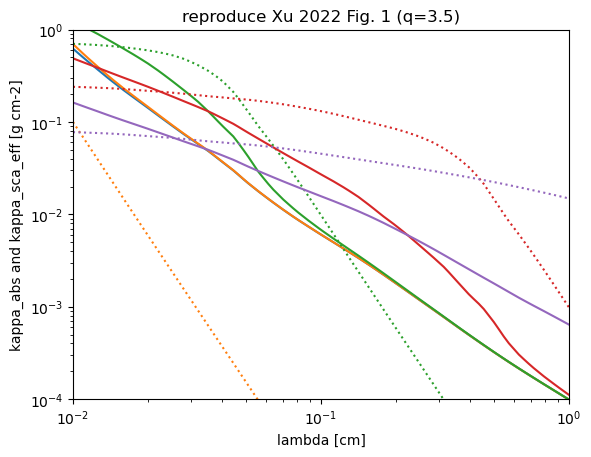

In [10]:
x = np.logspace(-2, 0, 100)
for amax in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    y = disk_opacity_lam.interp('log_kappa_abs', loglog=True, log_T=np.ones_like(x), log_lam=x, log_amax=amax*np.ones_like(x), q=np.exp(3.5)*np.ones_like(x))
    p,=plt.plot(x,y)
    y = disk_opacity_lam.interp('log_kappa_sca_eff', loglog=True, log_T=np.ones_like(x), log_lam=x, log_amax=amax*np.ones_like(x), q=np.exp(3.5)*np.ones_like(x))
    plt.plot(x,y,ls=':',color=p.get_color())
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e0)
plt.ylim(1e-4,1)
plt.xlabel('lambda [cm]')
plt.ylabel('kappa_abs and kappa_sca_eff [g cm-2]')
plt.title('reproduce Xu 2022 Fig. 1 (q=3.5)')
plt.show()

Text(0.5, 1.0, 'same as above but q=2.5')

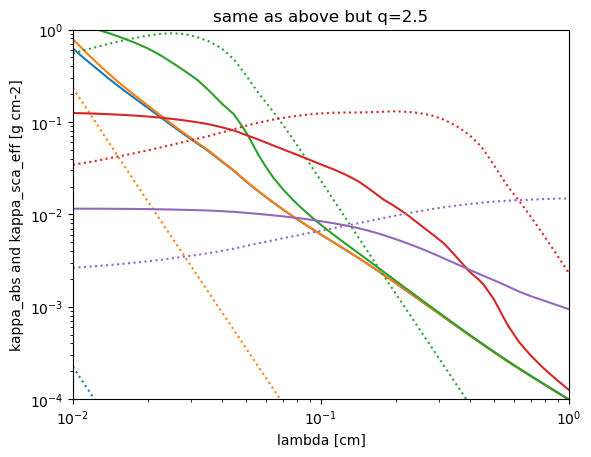

In [11]:
x = np.logspace(-2, 0, 100)
for amax in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    y = disk_opacity_lam.interp('log_kappa_abs', loglog=True, log_T=np.ones_like(x), log_lam=x, log_amax=amax*np.ones_like(x), q=np.exp(2.5)*np.ones_like(x))
    p,=plt.plot(x,y)
    y = disk_opacity_lam.interp('log_kappa_sca_eff', loglog=True, log_T=np.ones_like(x), log_lam=x, log_amax=amax*np.ones_like(x), q=np.exp(2.5)*np.ones_like(x))
    plt.plot(x,y,ls=':',color=p.get_color())
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,1e0)
plt.ylim(1e-4,1)
plt.xlabel('lambda [cm]')
plt.ylabel('kappa_abs and kappa_sca_eff [g cm-2]')
plt.title('same as above but q=2.5')
plt.show()

In [12]:
# compute mean opacities
lam_grid = np.exp(disk_opacity_lam.grid['log_lam'])
for i, log_T in enumerate(log_T_grid):
    iT = np.argmin(np.abs(log_T-disk_opacity_lam.grid['log_T']))
    nu = c_light/lam_grid
    T = np.exp(log_T)
    exp_nu_T = np.exp(h*nu/(kB*T))
    B_times_nu = nu**4 / (exp_nu_T-1) # arbitrary unit
    B_times_nu_norm = B_times_nu/np.sum(B_times_nu)
    # u = dB/dT
    u_times_nu = nu**4 / (exp_nu_T-1/exp_nu_T) * h*nu/kB/T**2
    u_times_nu_norm = u_times_nu/np.sum(u_times_nu)
    disk_opacity.data['log_kappa_abs_p'][i] = np.log(np.sum(np.exp(disk_opacity_lam.data['log_kappa_abs'][iT]) * B_times_nu_norm[:,None,None], axis=0))
    disk_opacity.data['log_kappa_abs_r'][i] = -np.log(np.sum(np.exp(-disk_opacity_lam.data['log_kappa_abs'][iT]) * u_times_nu_norm[:,None,None], axis=0))
    disk_opacity.data['log_kappa_sca_eff_p'][i] = np.log(np.sum(np.exp(disk_opacity_lam.data['log_kappa_sca_eff'][iT]) * B_times_nu_norm[:,None,None], axis=0))
    disk_opacity.data['log_kappa_sca_eff_r'][i] = -np.log(np.sum(np.exp(-disk_opacity_lam.data['log_kappa_sca_eff'][iT]) * u_times_nu_norm[:,None,None], axis=0))

disk_opacity.create_interp_fn_all_data()

/var/folders/w3/86cy1mvn3t5_sxhyqdwmz6bm0000gq/T/ipykernel_75886/3059036944.py:7: RuntimeWarning: overflow encountered in exp
  exp_nu_T = np.exp(h*nu/(kB*T))


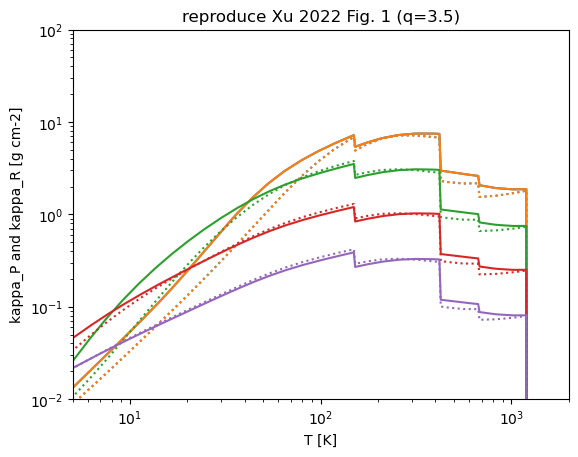

In [14]:
x = np.logspace(0, 3.5, 500)
for amax in [1e-3, 1e-3, 1e-2, 1e-1, 1]:
    y = disk_opacity.interp('log_kappa_abs_p', loglog=True, log_T=x, log_amax=amax*np.ones_like(x), q=np.exp(3.5)*np.ones_like(x))
    p,=plt.plot(x,y)
    y = disk_opacity.interp('log_kappa_abs_r', loglog=True, log_T=x, log_amax=amax*np.ones_like(x), q=np.exp(3.5)*np.ones_like(x))
    plt.plot(x,y,ls=':',color=p.get_color())
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,2000)
plt.ylim(1e-2,1e2)
plt.xlabel('T [K]')
plt.ylabel('kappa_P and kappa_R [g cm-2]')
plt.title('reproduce Xu 2022 Fig. 1 (q=3.5)')
plt.show()

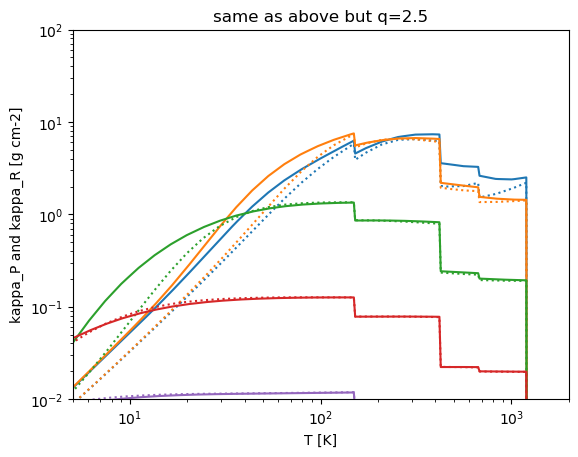

In [13]:
x = np.logspace(0, 3.5, 500)
for amax in [1e-4, 1e-3, 1e-2, 1e-1, 1]:
    y = disk_opacity.interp('log_kappa_abs_p', loglog=True, log_T=x, log_amax=amax*np.ones_like(x), q=np.exp(2.5)*np.ones_like(x))
    p,=plt.plot(x,y)
    y = disk_opacity.interp('log_kappa_abs_r', loglog=True, log_T=x, log_amax=amax*np.ones_like(x), q=np.exp(2.5)*np.ones_like(x))
    plt.plot(x,y,ls=':',color=p.get_color())
plt.xscale('log')
plt.yscale('log')
plt.xlim(5,2000)
plt.ylim(1e-2,1e2)
plt.xlabel('T [K]')
plt.ylabel('kappa_P and kappa_R [g cm-2]')
plt.title('same as above but q=2.5')
plt.show()

# Save the tables

In [17]:
update_opacity = False
if update_opacity:
    pickle.dump(disk_opacity, open('./data/opacity_tables/disk_opacity.pkl','wb'))
    pickle.dump(disk_opacity_lam, open('./data/opacity_tables/disk_opacity_lam.pkl','wb'))

In [18]:
disk_opacity

InterpTable object with 3 dims
Axes:
  [0] log_T, length=38
  [1] log_amax, length=15
  [2] q, length=5
Data fields, shape=[38, 15, 5]:
  log_kappa_abs_p
  log_kappa_abs_r
  log_kappa_sca_eff_p
  log_kappa_sca_eff_r

In [19]:
disk_opacity_lam

InterpTable object with 4 dims
Axes:
  [0] log_T, length=8
  [1] log_lam, length=121
  [2] log_amax, length=15
  [3] q, length=5
Data fields, shape=[8, 121, 15, 5]:
  log_kappa_abs
  log_kappa_sca_eff